#### Programa de Formación en ML & DS
## Introducción al Aprendizaje Automático
# Sesión 5: Random Forests y exploración aleatorizada

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import pandas as pd
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
from time import time


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def plot_labels(n_folds, n_classes, list_labels):
    ind = np.arange(n_folds)
    width = 0.15
    
    countings = []
    for labels in list_labels:
        labels = np.array(labels)
        countings.append([np.count_nonzero(labels == x) for x in range(n_classes)])
    
    class_bars = []
    for cls in range(n_classes):
        class_bars.append([l[cls] for l in countings])
    
    fig, ax = pl.subplots()
    i = 0
    for class_bar in class_bars:
        ax.bar(ind + width*i, class_bar, width, label='Clase '+str(i))
        i += 1
        
    ax.set_xticks(ind + 2*width / 3)
    ax.set_xticklabels(['Pliegue {}'.format(k) for k in range(n_folds)])
    pl.legend(loc="best")
    pl.title("Etiquetas")

# Árboles de decisión y Bagging

Considere el siguiente conjunto de datos

In [0]:
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split

np.random.seed(0)

X, y = make_circles(n_samples=1000, factor=.4, noise=.15)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    random_state=2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


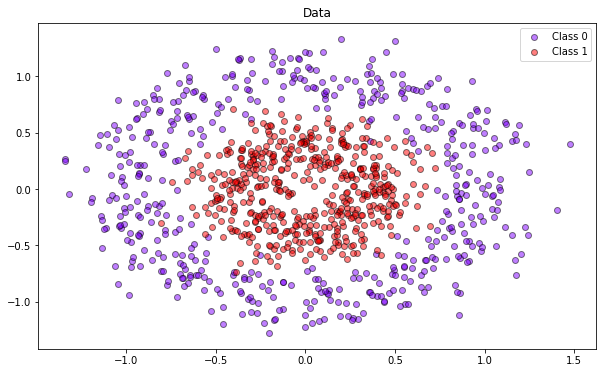

In [3]:
pl.figure(figsize = (10, 6))
plot_data(X, y)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

Vamos a entrenar un modelo de árbol de decisión para resolver este problema de clasificación.

In [0]:
from sklearn.tree import DecisionTreeClassifier

Entrenamos un árbol de decisión de profundidad máxima $5$

In [6]:
dt = DecisionTreeClassifier(max_depth=5)

dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Error en entrenamiento: 0.021666666666666612
Error en prueba: 0.06000000000000005


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


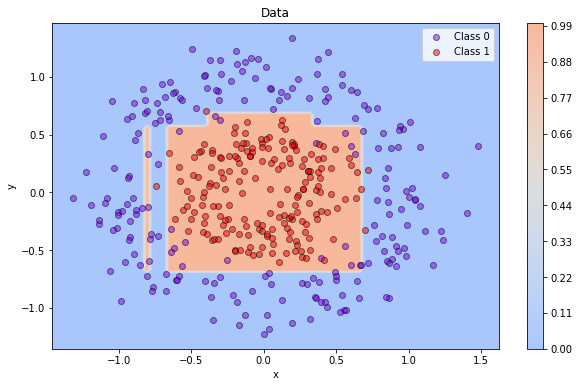

In [7]:
print('Error en entrenamiento: {}'.format(1-dt.score(X_train, y_train)))
print('Error en prueba: {}'.format(1-dt.score(X_test, y_test)))

pl.figure(figsize = (10, 6))
plot_decision_region(X_test, gen_pred_fun(dt))
plot_data(X_test, y_test)

El modelo presenta un error de generalización del $6\%$, además sus predicciones no se ajustan a la naturaleza de los datos

Problemas:
* En algunos casos, las franteras de decisión generadas por el árbol de decisión (paralelas a los ejes) no son lo suficientemente flexibles para capturar la no linealidad del conjunto de datos.
* Por otro lado, los árboles de decisión pueden crear reglas de decisión muy específicas que se ajustan demasiado a los datos de entrenamiento.
* Tambien son sensibles a pequeñas variaciones de los datos que pueden resultar en árboles totalmente distintos. Esto es un problema cuando se hace validación cruzada de k-pliegues.

**¿Cómo solucionar este problema?**


Vamos a utilizar una estrategia conocida como *clasificación por comité* o *ensamble de clasificadores*. Un ensamble de clasificadores combina diferentes algoritmos de aprendizaje para obtener un mejor desempeño predictivo. A continuación, presentamos una forma de cómo construír un ensamble de árboles de clasificación. Se entrenan diferentes árboles en diferentes subconjuntos de los datos de entrenamiento. Posteriormente cuando se va hacer una predicción para un nuevo dato, se obtienen las predicciones de todos los árboles y se regresa aquella clase de mayor frecuencia predicha.

<img src="https://drive.google.com/uc?export=view&id=1H_8wt2lK2p--pFzVZotUehFpOn-1_cXR">

A la técnica de la figura se le conoce como *bagging*. En el ejemplo siguiente vamos a utilizar la función `BaggingClassifier` la cual entrena un modelo usando esta estrategia. Los parámetros recibidos por la función son los siguientes:
*  `base_estimator`: Consiste en el estimador base que se va a entrenar sobre los diferentes subconjuntos del conjunto de datos de entrenamiento.
* `n_estimators`: Es el número de estimadores base que se van a usar para la estrategia de *bagging*.

Error en entrenamiento: 0.013333333333333308
Error en prueba: 0.04500000000000004


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


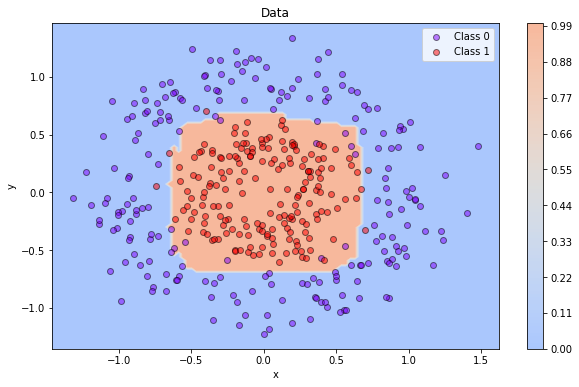

In [9]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=20)
bc.fit(X_train, y_train)

print('Error en entrenamiento: {}'.format(1-bc.score(X_train, y_train)))
print('Error en prueba: {}'.format(1-bc.score(X_test, y_test)))

pl.figure(figsize = (10, 6))
plot_decision_region(X_test, gen_pred_fun(bc))
plot_data(X_test, y_test)

# Random Forests

Existen varias alternativas para combinar y promediar árboles de decisión, una de las más usadas es Random Forest. Scikit-Learn provee una implementación a través de `sklearn.ensemble.RandomForestClassifier`. Más adelante se discuten los parámetros más importantes de esta implementación.

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


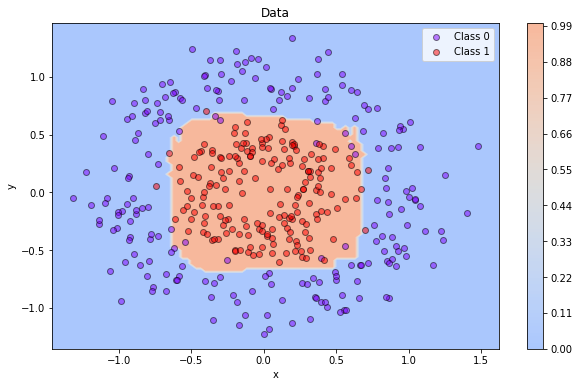

In [12]:
pl.figure(figsize = (10, 6))
plot_decision_region(X_test, gen_pred_fun(rf))
plot_data(X_test, y_test)

In [13]:
print('Error en entrenamiento: {}'.format(1-rf.score(X_train, y_train)))
print('Error en prueba: {}'.format(1-rf.score(X_test, y_test)))

Error en entrenamiento: 0.013333333333333308
Error en prueba: 0.040000000000000036


Mientras baja el error de generalización, observamos tambien que se adapta mejor a la naturaleza de los datos

## Intuición detrás de RandomForests

Random Forest es una técnica de **ensamble** que combina diferentes árboles de decisión. Estos árboles se entrenan en diferentes muestras del conjunto de datos, estos árboles pueden sobreajustarse, sin embargo la combinación de sus predicciones resulta en un clasificador con menor sobreajuste. Para entender la idea de cómo se construye este algoritmo, suponga que entrenamos los siguientes árboles para determinar si una persona está enferma o sana:

<img src="https://drive.google.com/uc?export=view&id=1_twQEtsjRjDHxcDh4cFGQ4cHnkKwmLY6">

## ¿Qué sucede si todos los árboles de clasificación son iguales?

## ¿Cómo logro que cada árbol de clasificación sea diferente?



## Algoritmo básico Random Forest

A diferencia del árbol común de decisión, los árboles de Random Forest se entrenan de una forma diferente. A continuación, presentamos el algoritmo básico de entrenamiento:

1. Para cada árbol se realiza el siguiente procedimiento:
    * Se escoge una muestra con reemplazo de tamaño $n$ del conjunto de entrenamiento.
    * Se seleccionan $m$ variables al azar de las variables disponibles
    * Se entrena un árbol sobre la muestra usando las $m$ variables repitiendo los siguientes pasos:
        * Se escoge la variable (y umbral) que genera la mejor partición
        * Se divide los datos en dos subconjuntos de acuerdo a la variable y el umbral
        * Si no se satisface un criterio de parada se aplica este procedimiento recursivamente sobre los subconjutos
2. Una vez cada árbol ha sido entrenado, se genera el ensamble de árboles.

## Implementación en Scikit-Learn

La implementación en Scikit-Learn nos permite controlar los siguientes parámetros:
* `n_estimators`: Número de árboles a entrenar
* `max_features`: Número de variables $m$ al azar que se tienen en cuenta para la construcción de cada árbol.

Un número grande de árboles resulta en un buen desempeño a costas del costo computacional. Ambos parámetros deben ser explorados usando validación cruzada. A continuación, usaremos el conjunto de datos `wine`.

In [14]:
!wget -O wine.data.txt "https://drive.google.com/uc?export=download&id=1eI5Djinvjqc-PrpT6mqjfpvkSNY2LZQI"

--2019-06-10 22:46:26--  https://drive.google.com/uc?export=download&id=1eI5Djinvjqc-PrpT6mqjfpvkSNY2LZQI
Resolving drive.google.com (drive.google.com)... 74.125.195.113, 74.125.195.100, 74.125.195.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4vj9nm5uecus097r3j38qm2j72ve02qi/1560204000000/17039964666782190292/*/1eI5Djinvjqc-PrpT6mqjfpvkSNY2LZQI?e=download [following]
--2019-06-10 22:46:27--  https://doc-0c-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/4vj9nm5uecus097r3j38qm2j72ve02qi/1560204000000/17039964666782190292/*/1eI5Djinvjqc-PrpT6mqjfpvkSNY2LZQI?e=download
Resolving doc-0c-94-docs.googleusercontent.com (doc-0c-94-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0c-94-docs.googleusercontent.com (doc-0c

In [0]:
df = pd.read_csv('wine.data.txt')

In [16]:
df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Generamos la matriz de características y el arreglo de etiquetas

In [0]:
X = df.drop(columns=['Class'], axis=1).values
y = df['Class'].values

Definimos la malla de parámetros:

In [0]:
max_features_params = [np.round(10**-1 * i, decimals=1) for i in range(1, 11, 1)]
param_grid = {'n_estimators': [2**i for i in range(2, 12)], 'max_features': max_features_params}

In [22]:
print('Número de árboles: {}'.format(param_grid['n_estimators']))

Número de árboles: [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]


In [23]:
print('Porcentaje de características a usar: {}'.format(param_grid['max_features']))

Porcentaje de características a usar: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


Creamos la partición de entrenamiento y prueba

In [0]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Corremos el modelo `GridSearchCV` usando la malla de parámetros

In [25]:
start = time()
clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, verbose=1, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)
print("GridSearchCV tomó {} segundos usando {} configuraciones".format(time() - start,
                                                                         len(clf.cv_results_['params'])))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:  1.3min


GridSearchCV tomó 138.47132277488708 segundos usando 100 configuraciones


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Usando `cv_results_` extraemos el desempeño promedio sobre cada configuración de parámetros

In [0]:
scores = clf.cv_results_['mean_test_score'].reshape(len(param_grid['max_features']),
                                                    len(param_grid['n_estimators']))

In [27]:
scores

array([[0.87903226, 0.93548387, 0.9516129 , 0.97580645, 0.98387097,
        0.98387097, 0.98387097, 0.98387097, 0.98387097, 0.98387097],
       [0.91129032, 0.97580645, 0.98387097, 0.97580645, 0.97580645,
        0.97580645, 0.98387097, 0.97580645, 0.98387097, 0.97580645],
       [0.95967742, 0.91935484, 0.96774194, 0.95967742, 0.97580645,
        0.97580645, 0.97580645, 0.97580645, 0.97580645, 0.97580645],
       [0.94354839, 0.95967742, 0.97580645, 0.95967742, 0.97580645,
        0.97580645, 0.97580645, 0.97580645, 0.97580645, 0.97580645],
       [0.90322581, 0.9516129 , 0.95967742, 0.97580645, 0.96774194,
        0.96774194, 0.97580645, 0.97580645, 0.97580645, 0.97580645],
       [0.95967742, 0.96774194, 0.94354839, 0.97580645, 0.97580645,
        0.97580645, 0.97580645, 0.96774194, 0.97580645, 0.97580645],
       [0.89516129, 0.94354839, 0.9516129 , 0.96774194, 0.97580645,
        0.97580645, 0.97580645, 0.97580645, 0.97580645, 0.97580645],
       [0.91935484, 0.9516129 , 0.9677419

Visualizamos la mejor combinación de parámetros:

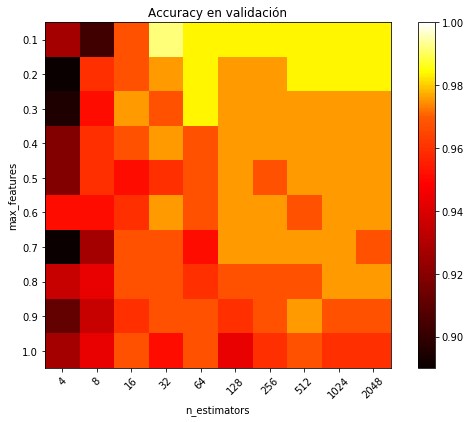

In [0]:
pl.figure(figsize=(10, 6))
pl.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.89, midpoint=0.97, vmax=1.))
pl.xlabel('n_estimators')
pl.ylabel('max_features')
pl.colorbar()
pl.xticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'], rotation=45)
pl.yticks(np.arange(len(param_grid['max_features'])), param_grid['max_features'])
pl.title('Accuracy en validación')
pl.show()

La mejor combinación de parámetros está dada por:

In [0]:
clf.best_params_

{'max_features': 0.1, 'n_estimators': 32}

In [0]:
clf.best_score_

0.9919354838709677

Finalmente, reportamos en el conjunto de prueba:

In [0]:
clf.score(X_test, y_test)

0.9814814814814815

## Importancia de características

Una ventaja muy significativa de usar Random Forests consiste en la posibilidad de obtener la importancia de las características del conjunto de datos. Esta importancia nos indica qué tanto una característica contribuye al desempeño en los nodos de los diferentes árboles.

A continuación, seguimos usando el conjunto de datos `wine` y obtenemos la importancia de las características del mejor modelo usando validación cruzada. Entrenemos de nuevo el modelo:

In [0]:
clf = RandomForestClassifier(n_estimators=32, max_features=.1)

clf.fit(X_train, y_train);

Extraemos la importancia de las características

In [0]:
clf.feature_importances_

array([0.06062734, 0.08168618, 0.03344765, 0.03840975, 0.06315486,
       0.08530752, 0.08441509, 0.0640607 , 0.05141958, 0.10597256,
       0.0950197 , 0.10509683, 0.13138224])

A continuación ordenamos las características por su importancia

In [0]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Importancia de características:")

for f in range(X_train.shape[1]):
    print("Característica %s (%f)" % (df.columns[int(1+indices[f])], importances[indices[f]]))

Importancia de características:
Característica Proline (0.131382)
Característica Color (0.105973)
Característica OD280/OD315 (0.105097)
Característica Hue (0.095020)
Característica Phenols (0.085308)
Característica Flavanoids (0.084415)
Característica Malic_acid (0.081686)
Característica Nonflavanoid (0.064061)
Característica Magnesium (0.063155)
Característica Alcohol (0.060627)
Característica Proanthocyanins (0.051420)
Característica Alcalinity (0.038410)
Característica Ash (0.033448)


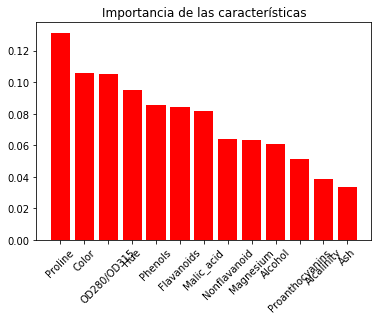

In [0]:
plt.figure()
plt.title("Importancia de las características")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
xticks_labels = [df.columns[1+i] for i in indices]
plt.xticks(range(X.shape[1]), xticks_labels, rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

# Optimización aleatoria de parámetros

A pesar de las ventajas que ofrece `GridSearchCV` sobre la exploración sistemática de los hiperparámetros de un modelo, puede gastar un tiempo considerable en esta exploración. Scikit-Learn permite hacer también una exploración aleatoria de los parámetros, la cual se ha demostrado empiricamente que es más eficiente que optimizar los parámetros usando una malla con `GridSearchCV` ([Referencia](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)). `RandomizedSearchCV` implementa una búsqueda aleatoria sobre los parámetros. El rango de exploración de los parámetros se puede especificar de la siguiente manera:

* Usando una lista:
    * `"criterion": ["gini", "entropy"]`
* Usando una distribución discreta uniforme:
    * `"n_estimators": randint(4, 2048)`
    * `randint` proviene de `scipy.stats`. Este genera una distribución discreta entre 4 y 2048. 
* Usando una distribución uniforme:
    * `"max_features": uniform()`
    * `uniform` proviene de `scipy.stats`. Este genera una distribución uniforme entre 0 y 1.
    
`RandomizedSearchCV` puede recibir tanto listas de elementos como distribuciones de probabilidad, las cuales deben ser especificadas usando `scipy.stats`. A continuación, creamos nuestro estimador y definimos la distribución de parámetros:

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform 
from scipy.stats import randint

clf = RandomForestClassifier()

param_dist = {"n_estimators": randint(4, 800),
              "max_features": uniform()}

`n_iter_search` nos define el número de configuraciones que vamos a extraer de la distribución de parámetros.

In [0]:
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, 
                                   n_jobs=-1, verbose=2)

`RandomizedSearchCV` también soporta la ejecución en paralelo usando `n_jobs=-1`. También podemos especificar el número de pliegues a usar usando `cv=5`

In [0]:
start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV tomó {} segundos usando {} configuraciones".format(time() - start,
                                                                               n_iter_search))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV tomó 43.52226448059082 segundos usando 20 configuraciones


Extraemos los resultados con mejor desempeño promedio:

In [0]:
cv_results = pd.DataFrame(random_search.cv_results_)

cv_results = cv_results[['param_n_estimators', 'param_max_features', 'mean_test_score']]
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,param_n_estimators,param_max_features,mean_test_score
17,277,0.0993431,0.983871
3,466,0.0979188,0.983871
6,623,0.124381,0.983871
13,476,0.165854,0.983871
0,768,0.293991,0.975806


Verificamos la mejor configuración y su puntaje sobre todas las particiones de validación:

In [0]:
random_search.best_params_

{'max_features': 0.0979187987907415, 'n_estimators': 466}

In [0]:
random_search.best_score_

0.9838709677419355

Reportamos el score de generalización:

In [0]:
random_search.score(X_test, y_test)

1.0